# Загрузка данных, выделение целевого признака, проверка баланса классов

In [1]:
import pandas as pd
import numpy as np
from cl_metrics import accuracy, precision, recall, f1
from my_knn import KNN

In [2]:
df = pd.read_csv(r"D:\MachineLearning\data\airlines_label_encoding.csv").drop(["Unnamed: 0"], axis=1)

In [3]:
df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,305,3036,144,58,4,1195,131.0,0
1,298,315,84,218,7,707,145.0,0
2,219,6673,265,204,5,499,42.0,1
3,303,3668,229,218,2,810,70.0,1
4,17,623,162,226,5,985,143.0,0


Delay - целевой признак

In [4]:
df["Delay"].value_counts()

Delay
0    159671
1     82058
Name: count, dtype: int64

Видим достаточно сильный дисбаланс классов, проведём балансировку

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
transformed_feat_df, transformed_label_df = smote.fit_resample(df.drop(["Delay"], axis=1), df["Delay"])
X = transformed_feat_df
y = transformed_label_df

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=transformed_label_df, train_size=0.8)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [8]:
def print_scores(y_true, y_pred):
    print(f"Accuracy: {round(accuracy_score(y_true, y_pred), 2)}")
    print(f"Precision: {round(precision_score(y_true, y_pred), 2)}")
    print(f"Recall: {round(recall_score(y_true, y_pred), 2)}")
    print(f"f1_score: {round(f1_score(y_true, y_pred), 2)}")
    print(confusion_matrix(y_true, y_pred))

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

D:\MachineLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

## Подборка гиперпараметров

In [11]:
parameters = {"C": np.arange(0.1, 1, 0.1)}

### Grid Search

In [12]:
lr_grid = GridSearchCV(LogisticRegression(solver="liblinear"), parameters, n_jobs=-1).fit(X_train, y_train)

In [13]:
lr_grid.best_params_

{'C': np.float64(0.4)}

In [14]:
y_pred = lr_grid.predict(X_test)
scores_lr = [accuracy_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), f1_score(y_pred, y_test)]
print_scores(y_test, y_pred)

Accuracy: 0.58
Precision: 0.58
Recall: 0.58
f1_score: 0.58
[[18313 13621]
 [13389 18546]]


In [15]:
my_scores_lr = [accuracy(y_pred, y_test.to_numpy()), precision(y_pred, y_test.to_numpy()), recall(y_pred, y_test.to_numpy()), f1(y_pred, y_test.to_numpy())]

### Randomized Search

In [16]:
lr_rand = RandomizedSearchCV(LogisticRegression(solver="liblinear"), parameters, n_jobs=-1).fit(X_train, y_train)

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [17]:
lr_rand.best_params_

{'C': np.float64(0.4)}

In [18]:
y_pred = lr_rand.predict(X_test)
print_scores(y_test, y_pred)

Accuracy: 0.58
Precision: 0.58
Recall: 0.58
f1_score: 0.58
[[18313 13621]
 [13389 18546]]


### Optuna

In [19]:
import optuna

In [20]:
def objective(trial):
    C = trial.suggest_loguniform('alpha', 1e-1, 1e2)
    model = LogisticRegression(solver="liblinear", C=C).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_prams_lr_optuna = study.best_params

[I 2025-04-09 21:00:24,569] A new study created in memory with name: no-name-6514bd08-68f3-4cb8-867a-34d5dbc7f96d
C:\Users\Denis\AppData\Local\Temp\ipykernel_16020\1695546425.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('alpha', 1e-1, 1e2)
[I 2025-04-09 21:00:28,291] Trial 0 finished with value: 0.577588501463934 and parameters: {'alpha': 82.88256359102138}. Best is trial 0 with value: 0.577588501463934.
C:\Users\Denis\AppData\Local\Temp\ipykernel_16020\1695546425.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('alpha', 1e-1, 1e2)
[I 2025-04-09 21:00:31,690] Trial 1 finished with value: 0.5778390142322

In [22]:
study.best_params

{'alpha': 4.340786852282229}

In [23]:
lr_optuna = LogisticRegression(C=best_prams_lr_optuna['alpha']).fit(X_train, y_train)

D:\MachineLearning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
y_pred = lr_optuna.predict(X_test)
print_scores(y_test, y_pred)

Accuracy: 0.58
Precision: 0.58
Recall: 0.57
f1_score: 0.58
[[18492 13442]
 [13574 18361]]


## Кросс-валидация

In [25]:
from sklearn.model_selection import cross_validate

cross_scores_lr = cross_validate(LogisticRegression(solver="liblinear"), X, y, scoring=('accuracy', 'precision', 'recall', 'f1'))
print(f"Accuracy: {round(cross_scores_lr['test_accuracy'].mean(), 2)}")
print(f"Precision: {round(cross_scores_lr['test_precision'].mean(), 2)}")
print(f"Recall: {round(cross_scores_lr['test_recall'].mean(), 2)}")
print(f"f1_score: {round(cross_scores_lr['test_f1'].mean(), 2)}")

Accuracy: 0.57
Precision: 0.57
Recall: 0.58
f1_score: 0.57


# kNN

In [26]:
def kNN_with_metric(metric, X_train, y_train):
    return KNeighborsClassifier(metric=metric, n_jobs=-1, n_neighbors=3).fit(X_train, y_train)

## С отложенной выборкой

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
metrics = ["l1", "l2"]
for metric in metrics:
    print(f"Результаты при metric = {metric}")
    knn = kNN_with_metric(metric, X_train, y_train)
    y_pred = knn.predict(X_test)
    print_scores(y_test, y_pred)
    print("\n------------------------------------------")

Результаты при metric = l1
Accuracy: 0.65
Precision: 0.64
Recall: 0.66
f1_score: 0.65
[[20314 11620]
 [11000 20935]]

------------------------------------------
Результаты при metric = l2
Accuracy: 0.64
Precision: 0.64
Recall: 0.66
f1_score: 0.65
[[20030 11904]
 [10953 20982]]

------------------------------------------


In [29]:
parameters = {"metric": ["l1", "l2"], "n_neighbors": np.arange(3, 7)}

### Grid Search

In [30]:
knn_grid = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1).fit(X_train, y_train)
knn_grid.best_params_

{'metric': 'l1', 'n_neighbors': np.int64(3)}

In [31]:
y_pred = knn_grid.predict(X_test)
print_scores(y_test, y_pred)

Accuracy: 0.65
Precision: 0.64
Recall: 0.66
f1_score: 0.65
[[20314 11620]
 [11000 20935]]


In [32]:
scores_knn = [accuracy_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), f1_score(y_pred, y_test)]

### Randomized Search

In [33]:
knn_random = RandomizedSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1).fit(X_train, y_train)
knn_grid.best_params_

D:\MachineLearning\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'metric': 'l1', 'n_neighbors': np.int64(3)}

In [34]:
y_pred = knn_grid.predict(X_test)
print_scores(y_test, y_pred)

Accuracy: 0.65
Precision: 0.64
Recall: 0.66
f1_score: 0.65
[[20314 11620]
 [11000 20935]]


## Кросс-валидация

In [35]:
def print_cross_validate(scores):
    print(f"Accuracy: {round(scores['test_accuracy'].mean(), 2)}")
    print(f"Precision: {round(scores['test_precision'].mean(), 2)}")
    print(f"Recall: {round(scores['test_recall'].mean(), 2)}")
    print(f"f1_score: {round(scores['test_f1'].mean(), 2)}")

In [36]:
cross_scores_knn = cross_validate(KNeighborsClassifier(metric="l1"), X, y, scoring=('accuracy', 'precision', 'recall', 'f1'))

In [37]:
print_cross_validate(cross_scores_knn)

Accuracy: 0.64
Precision: 0.64
Recall: 0.65
f1_score: 0.64


# Naive Bayes

## С отложенной выборкой

In [38]:
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, MultinomialNB

models_name = ["GaussianNB", "ComplementNB", "BernoulliNB", "MultinomialNB"]
models = [GaussianNB(), ComplementNB(), BernoulliNB(), MultinomialNB()]
bayes_models = [model.fit(X_train, y_train) for model in models]
predicts_of_bayes_models = [model.predict(X_test) for model in bayes_models]

for i, pred in enumerate(predicts_of_bayes_models):
    if i == 0:
        scores_nb = [accuracy_score(pred, y_test), precision_score(pred, y_test), recall_score(pred, y_test), f1_score(pred, y_test)]
    print(f"Модель: {models_name[i]}")
    print_scores(y_test, pred)
    print("---------------------------")

Модель: GaussianNB
Accuracy: 0.6
Precision: 0.6
Recall: 0.63
f1_score: 0.61
[[18291 13643]
 [11830 20105]]
---------------------------
Модель: ComplementNB
Accuracy: 0.55
Precision: 0.54
Recall: 0.64
f1_score: 0.58
[[14424 17510]
 [11511 20424]]
---------------------------
Модель: BernoulliNB
Accuracy: 0.5
Precision: 0.5
Recall: 0.96
f1_score: 0.66
[[ 1523 30411]
 [ 1212 30723]]
---------------------------
Модель: MultinomialNB
Accuracy: 0.55
Precision: 0.54
Recall: 0.64
f1_score: 0.58
[[14424 17510]
 [11511 20424]]
---------------------------


## Кросс-валидация

In [39]:
for model, model_name in zip(models, models_name):
    if model_name == "GaussianNB":
        cross_scores_nb = cross_validate(model, X, y, scoring=('accuracy', 'precision', 'recall', 'f1'))
    scores = cross_validate(model, X, y, scoring=('accuracy', 'precision', 'recall', 'f1'))
    print(f"Модель: {model_name}")
    print_cross_validate(scores)
    print("---------------------------")

Модель: GaussianNB
Accuracy: 0.6
Precision: 0.59
Recall: 0.63
f1_score: 0.61
---------------------------
Модель: ComplementNB
Accuracy: 0.55
Precision: 0.54
Recall: 0.64
f1_score: 0.59
---------------------------
Модель: BernoulliNB
Accuracy: 0.51
Precision: 0.5
Recall: 0.96
f1_score: 0.66
---------------------------
Модель: MultinomialNB
Accuracy: 0.55
Precision: 0.54
Recall: 0.64
f1_score: 0.59
---------------------------


# Linear SVM

## С отложенной выборкой

In [40]:
from sklearn.svm import SVC, LinearSVC

svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
print_scores(y_test, y_pred)

Accuracy: 0.58
Precision: 0.57
Recall: 0.58
f1_score: 0.58
[[18124 13810]
 [13269 18666]]


In [41]:
scores_lsvm = [accuracy_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), f1_score(y_pred, y_test)]

## Кросс-валидация

In [42]:
cross_scores_lsvm = cross_validate(LinearSVC(), X, y, scoring=("accuracy", "precision", "recall", "f1"))
print_cross_validate(cross_scores_lsvm)

Accuracy: 0.57
Precision: 0.57
Recall: 0.58
f1_score: 0.57


# SVM с ядерными функциями

In [43]:
sample_len = 20

X_sample = pd.DataFrame(columns=X.columns)
y_sample = pd.Series(name=y.name)

count_0 = 0
count_1 = 0

for i in range(len(y)):
    if y.iloc[i] == 0 and count_0 < sample_len // 2:
        X_sample.loc[i] = X.iloc[i]
        y_sample.loc[i] = y.iloc[i]
        count_0 += 1

    elif y.iloc[i] == 1 and count_1 < sample_len // 2:
        X_sample.loc[i] = X.iloc[i]
        y_sample.loc[i] = y.iloc[i]
        count_1 += 1

    if count_0 >= sample_len // 2 and count_1 >= sample_len // 2:
        break
        
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_sample, y_sample, test_size=0.2)
y_sample.value_counts()

Delay
0    10
1    10
Name: count, dtype: int64

In [44]:
from sklearn.svm import SVC

## Kernel: poly

In [45]:
parameters = {
    "degree": np.arange(2, 3, 1),
    "gamma": np.arange(0.13, 0.15, 0.01),
    "C": np.arange(0.1, 1, 0.2)
}

In [46]:
lin_svc_rand = RandomizedSearchCV(SVC(kernel="poly"), parameters, n_jobs=-1).fit(Xs_train, ys_train)
lin_svc_rand.best_params_

{'gamma': np.float64(0.13), 'degree': np.int64(2), 'C': np.float64(0.1)}

In [47]:
y_pred = lin_svc_rand.predict(Xs_test)

In [48]:
scores_psvm = [accuracy_score(y_pred, ys_test), precision_score(y_pred, ys_test), recall_score(y_pred, ys_test), f1_score(y_pred, ys_test)]

In [49]:
print_scores(ys_test, y_pred)

Accuracy: 0.5
Precision: 1.0
Recall: 0.5
f1_score: 0.67
[[0 0]
 [2 2]]


## Kernel: rbf

In [50]:
parameters = {
    "gamma": np.arange(0.13, 0.15, 0.01),
    "C": np.arange(0.1, 1, 0.2)
}

In [51]:
rbf_svc_rand = RandomizedSearchCV(SVC(kernel="rbf"), parameters, n_jobs=-1).fit(Xs_train, ys_train)
rbf_svc_rand.best_params_

{'gamma': np.float64(0.13), 'C': np.float64(0.1)}

In [52]:
y_pred = rbf_svc_rand.predict(Xs_test)

In [53]:
scores_rbfsvm = [accuracy_score(y_pred, ys_test), precision_score(y_pred, ys_test), recall_score(y_pred, ys_test), f1_score(y_pred, ys_test)]

D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
print_scores(ys_test, y_pred)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
f1_score: 0.0
[[0 0]
 [4 0]]


D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Kernel: sigmoid

In [55]:
parameters = {
    "gamma": np.arange(0.13, 0.15, 0.01),
    "C": np.arange(0.1, 1, 0.2)
}

In [56]:
sigm_svc_rand = RandomizedSearchCV(SVC(kernel="sigmoid"), parameters, n_jobs=-1).fit(Xs_train, ys_train)
sigm_svc_rand.best_params_

{'gamma': np.float64(0.13), 'C': np.float64(0.1)}

In [57]:
y_pred = sigm_svc_rand.predict(Xs_test)

In [58]:
scores_sigm = [accuracy_score(y_pred, ys_test), precision_score(y_pred, ys_test), recall_score(y_pred, ys_test), f1_score(y_pred, ys_test)]

D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
print_scores(ys_test, y_pred)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
f1_score: 0.0
[[0 0]
 [4 0]]


D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Визуализация

## Влияние k на точность KNN

In [60]:
import matplotlib.pyplot as plt

In [61]:
accuracy_list = []
for k in range(2, 7):
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

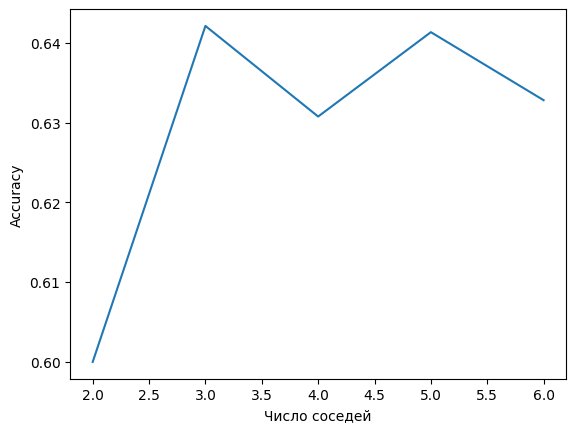

In [62]:
x = range(2, 7)

fig, ax = plt.subplots()

ax.plot(x, accuracy_list)
plt.xlabel("Число соседей")
plt.ylabel("Accuracy")

## ROC curve

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

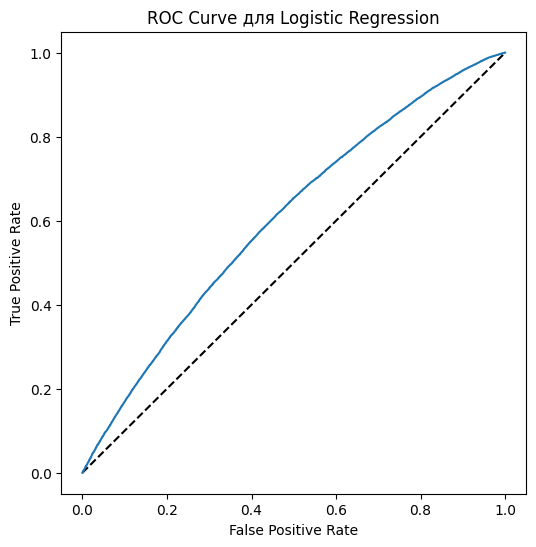

In [64]:
y_scores = lr_grid.predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для Logistic Regression')
plt.show()

In [65]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.6053118986240105


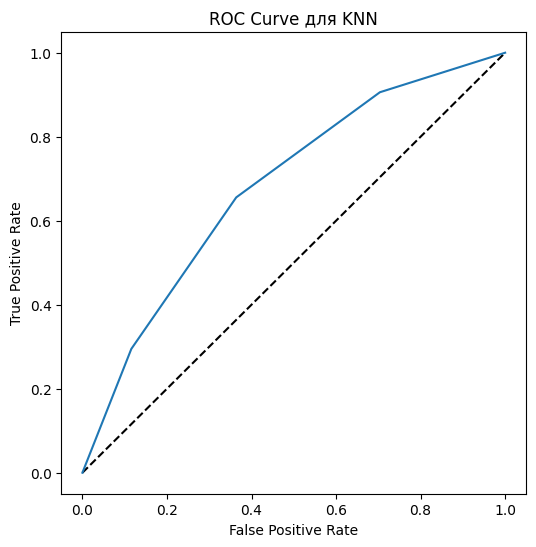

In [66]:
y_scores = knn_grid.predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для KNN')
plt.show()

In [67]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.6826467496287969


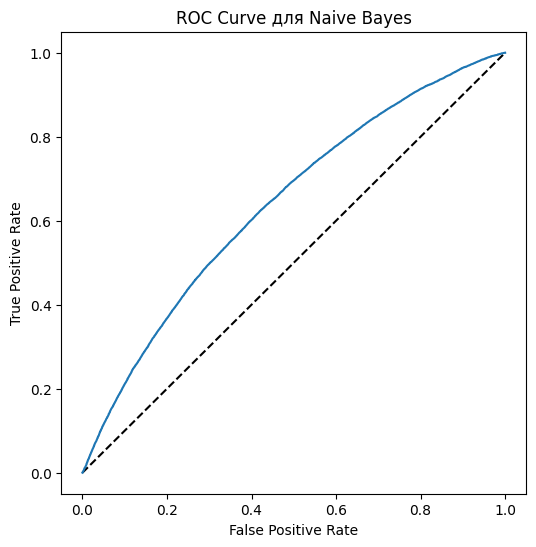

In [68]:
y_scores = models[0].predict_proba(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для Naive Bayes')
plt.show()

In [69]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.6396312732218592


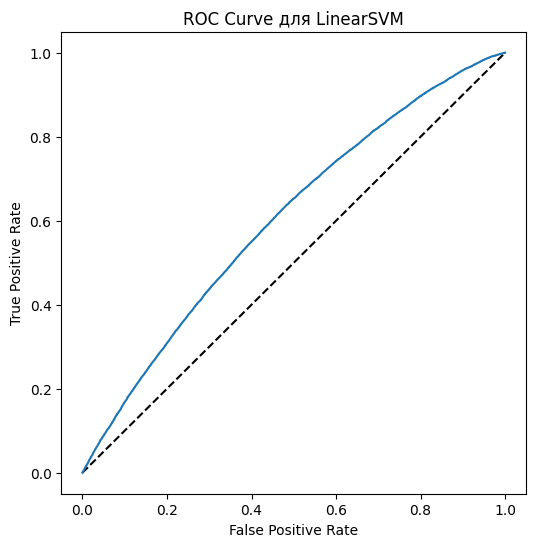

In [70]:
y_scores = svm.decision_function(X_test)
# Вычислить ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Построить ROC кривую
fig = plt.figure(figsize=(6, 6))
# Постройте диагональную линию 50%
plt.plot([0, 1], [0, 1], 'k--')
# Построить FPR and TPR, которые достигаются нашей моделью
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve для LinearSVM')
plt.show()

In [71]:
auc = roc_auc_score(y_test,y_scores)
print(auc)

0.6045573264271996


# Тут Roc curve для ядровых SVM

# Сравниваем свой KNN с эталонным

In [72]:
len_sample_knn = 2000

In [73]:
knn = KNN(k=3)
knn.fit(X_train[:len_sample_knn].to_numpy(), y_train[:len_sample_knn].to_numpy())

In [74]:
y_pred = knn.predict(X_test[:len_sample_knn].to_numpy())
y_pred_train = knn.predict(X_train[:len_sample_knn].to_numpy())

In [75]:
print_scores(y_pred, y_test[:len_sample_knn])

Accuracy: 0.51
Precision: 0.53
Recall: 0.49
f1_score: 0.51
[[510 446]
 [533 511]]


In [76]:
knn_sk = KNeighborsClassifier(n_neighbors=3).fit(X_train[:len_sample_knn], y_train[:len_sample_knn])

In [77]:
y_pred2 = knn_sk.predict(X_test[:len_sample_knn])
y_pred2_train = knn_sk.predict(X_train[:len_sample_knn])

In [78]:
print_scores(y_pred2, y_test[:len_sample_knn])

Accuracy: 0.51
Precision: 0.53
Recall: 0.49
f1_score: 0.51
[[510 447]
 [533 510]]


In [79]:
columns = pd.MultiIndex.from_tuples([
    ('Train Data', 'F1'),
    ('Train Data', 'Accuracy'),
    ('Train Data', 'Precision'),
    ('Train Data', 'Recall'),
    ('Test Data', 'F1'),
    ('Test Data', 'Accuracy'),
    ('Test Data', 'Precision'),
    ('Test Data', 'Recall'),
])

# Данные для таблицы
data = [
    [
        'kNN из Sklearn',
        f"{round(f1_score(y_pred_train, y_test[:len_sample_knn]), 2):.2f}",
        f"{round(accuracy_score(y_pred_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(precision_score(y_pred_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(recall_score(y_pred_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(f1_score(y_pred, y_test[:len_sample_knn]), 2):.2f}",
        f"{round(accuracy_score(y_pred, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(precision_score(y_pred, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(recall_score(y_pred, y_test[:len_sample_knn]), 4):.4f}",
    ],
    [
        'программный kNN',
        f"{round(f1_score(y_pred2_train, y_test[:len_sample_knn]), 2):.2f}",
        f"{round(accuracy_score(y_pred2_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(precision_score(y_pred2_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(recall_score(y_pred2_train, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(f1_score(y_pred2, y_test[:len_sample_knn]), 2):.2f}",
        f"{round(accuracy_score(y_pred2, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(precision_score(y_pred2, y_test[:len_sample_knn]), 4):.4f}",
        f"{round(recall_score(y_pred2, y_test[:len_sample_knn]), 4):.4f}",
    ]
]

# Создаем DataFrame
df = pd.DataFrame(data, columns=['Классификатор'] + columns.tolist())

# Устанавливаем мультииндекс для столбцов
df.columns = pd.MultiIndex.from_tuples([('Классификатор', '')] + columns.tolist())

# Выравниваем отображение
df.style.set_properties(**{'text-align': 'center'})

Свой алгоритм работает намного дольше, так как там не оптимизирован поиск расстояния между точками

# Подводим итоги по всем алгоритмам

In [80]:
def format_metric(value, metric_name):
    if value == "-":
        return value
    if metric_name == 'F1':
        return f"{round(value, 2):.2f}"
    else:
        return f"{round(value, 4):.4f}"

In [81]:
columns = pd.MultiIndex.from_tuples([
    ('Метод hold-out (отложенная выборка)', 'Accuracy'),
    ('Метод hold-out (отложенная выборка)', 'Precision'),
    ('Метод hold-out (отложенная выборка)', 'Recall'),
    ('Метод hold-out (отложенная выборка)', 'F1'),
    ('Метод k-fold (кросс-валидация)', 'Accuracy'),
    ('Метод k-fold (кросс-валидация)', 'Precision'),
    ('Метод k-fold (кросс-валидация)', 'Recall'),
    ('Метод k-fold (кросс-валидация)', 'F1')
])

# Данные для таблицы
data = [
    [
        'Logistic Regression',
        f"{round(scores_lr[0], 4):.4f}",
        f"{round(scores_lr[1], 4):.4f}",
        f"{round(scores_lr[2], 4):.4f}",
        f"{round(scores_lr[3], 2):.2f}",
        f"{round(cross_scores_lr['test_accuracy'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_precision'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_recall'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_f1'].mean(), 2):.2f}",
    ],
    [
        'Logistic Regression with my scores',
        f"{round(my_scores_lr[0], 4):.4f}",
        f"{round(my_scores_lr[1], 4):.4f}",
        f"{round(my_scores_lr[2], 4):.4f}",
        f"{round(my_scores_lr[3], 2):.2f}",
        f"{round(cross_scores_lr['test_accuracy'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_precision'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_recall'].mean(), 4):.4f}",
        f"{round(cross_scores_lr['test_f1'].mean(), 2):.2f}",
    ],
    [
        'KNN',
        f"{round(scores_knn[0], 4):.4f}",
        f"{round(scores_knn[1], 4):.4f}",
        f"{round(scores_knn[2], 4):.4f}",
        f"{round(scores_knn[3], 2):.2f}",
        f"{round(cross_scores_knn['test_accuracy'].mean(), 4):.4f}",
        f"{round(cross_scores_knn['test_precision'].mean(), 4):.4f}",
        f"{round(cross_scores_knn['test_recall'].mean(), 4):.4f}",
        f"{round(cross_scores_knn['test_f1'].mean(), 2):.2f}",
    ],
    [
        'Naive Bayes',
        f"{round(scores_nb[0], 4):.4f}",
        f"{round(scores_nb[1], 4):.4f}",
        f"{round(scores_nb[2], 4):.4f}",
        f"{round(scores_nb[3], 2):.2f}",
        f"{round(cross_scores_nb['test_accuracy'].mean(), 4):.4f}",
        f"{round(cross_scores_nb['test_precision'].mean(), 4):.4f}",
        f"{round(cross_scores_nb['test_recall'].mean(), 4):.4f}",
        f"{round(cross_scores_nb['test_f1'].mean(), 2):.2f}",
    ],
    [
        'Linear SVM',
        f"{round(scores_lsvm[0], 4):.4f}",
        f"{round(scores_lsvm[1], 4):.4f}",
        f"{round(scores_lsvm[2], 4):.4f}",
        f"{round(scores_lsvm[3], 2):.2f}",
        f"{round(cross_scores_lsvm['test_accuracy'].mean(), 4):.4f}",
        f"{round(cross_scores_lsvm['test_precision'].mean(), 4):.4f}",
        f"{round(cross_scores_lsvm['test_recall'].mean(), 4):.4f}",
        f"{round(cross_scores_lsvm['test_f1'].mean(), 2):.2f}",
    ],
    [
        'Poly SVM',
        f"{round(scores_psvm[0], 4):.4f}",
        f"{round(scores_psvm[1], 4):.4f}",
        f"{round(scores_psvm[2], 4):.4f}",
        f"{round(scores_psvm[3], 2):.2f}",
        "-", "-", "-", "-"
    ],
    [
        'Rbf SVM',
        f"{round(scores_rbfsvm[0], 4):.4f}",
        f"{round(scores_rbfsvm[1], 4):.4f}",
        f"{round(scores_rbfsvm[2], 4):.4f}",
        f"{round(scores_rbfsvm[3], 2):.2f}",
        "-", "-", "-", "-"
    ],
    [
        'Sigmoid SVM',
        f"{round(scores_sigm[0], 4):.4f}",
        f"{round(scores_sigm[1], 4):.4f}",
        f"{round(scores_sigm[2], 4):.4f}",
        f"{round(scores_sigm[3], 2):.2f}",
        "-", "-", "-", "-"
    ]
]

# Создаем DataFrame
df = pd.DataFrame(data, columns=['Классификатор'] + columns.tolist())

# Устанавливаем мультииндекс для столбцов
df.columns = pd.MultiIndex.from_tuples([('Классификатор', '')] + columns.tolist())

# Форматирование
df.style.set_properties(**{'text-align': 'center'})

# Строим итоговую модель классификаторов

In [84]:
from sklearn.metrics import classification_report

In [85]:
classifiers = {
    'Logistic Regression': lr_grid,
    'KNN classifier': knn_grid,
    'Naive Bayes': models[0],
    'Linear SVM': svm,
    'Poly SVM': lin_svc_rand,
    'Rbf SVM': rbf_svc_rand,
    'Sigmoid SVM': sigm_svc_rand
}

In [87]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Logistic Regression: 57.7% 
              precision    recall  f1-score   support

           0       0.58      0.57      0.58     31934
           1       0.58      0.58      0.58     31935

    accuracy                           0.58     63869
   macro avg       0.58      0.58      0.58     63869
weighted avg       0.58      0.58      0.58     63869

Accuracy (train) for KNN classifier: 64.6% 
              precision    recall  f1-score   support

           0       0.65      0.64      0.64     31934
           1       0.64      0.66      0.65     31935

    accuracy                           0.65     63869
   macro avg       0.65      0.65      0.65     63869
weighted avg       0.65      0.65      0.65     63869

Accuracy (train) for Naive Bayes: 60.1% 
              precision    recall  f1-score   support

           0       0.61      0.57      0.59     31934
           1       0.60      0.63      0.61     31935

    accuracy                           0.60     

D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\MachineLearning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\MachineLearning\venv\Lib\site-packages\s

# Вывод 
Лучше всего показала себя модель KNN с метрикой l1 и количеством соседей 3. Также этот алгоритм способен обработать такое количество данных. Ядровый SVM же работают очень долго, из-за чего обучить модели на всей выборке не представляется возможным за разумное количество времени. 

Собственно написанный KNN работает так же, как и KNN из sklearn, однако он намного медленнее, потому что поиск расстояния между точками не оптимизирован, а просто идёт полный перебор.

Остальные модели показали себя довольно плохо по сравнению с KNN. Из accuracy приближается к 50%.

Впринципе на данном датасете получить большие метрики сложно. Возможно их дас ядерный SVM, если обучить его на всей выбоке.